## K-Means Clustering

HyperionDev - Data Science Skills Bootcamp (Task 23)

#### Categorising countries

**Objective:** To group countries using socio-economic and health factors to determine the development status of the country.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Random state seed
rseed = 42

## Load and explore data

**Data Source**

Provided dataset: "Country-data.csv"

The data used in this task was originally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

**Dataset Attributes**  

| Variable | Description |
|:---------|:------------| 
| country | Name of the country. |
| child_mort | Death of children under 5 years of age per 1000 live births. |
| exports | Exports of goods and services per capita. Given as a percentage of the GDP per capita. |
| health | Total health spending per capita. Given as a percentage of GDP per capita. |
| imports | Imports of goods and services per capita. Given as a percentage of the GDP per capita. |
| income | Net income per person. |
| inflation | The measurement of the annual growth rate of the Total GDP. |
| life_expec | The average number of years a new born child would live if the current mortality patterns remain the same. |
| total_fer | The number of children that would be born to each woman if the current age-fertility rates remains the same. |
| gdpp | The GDP per capita. Calculated as the Total GDP divided by the total population. |

In [ ]:
# Import the dataset
country = pd.read_csv('Country-data.csv')

# Preview
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
# Check the shape
rows, columns = country.shape
print(f'This dataset contains {rows} rows (features) and {columns} columns (variables).')

This dataset contains 167 rows (features) and 10 columns (variables).


In [ ]:
# Check datatypes & counts
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We see that only one column ("country", index 0) has non numerical values. We will drop that column later in the task. 

In [ ]:
# Get descriptive statistics
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [ ]:
# Identify any missing data
country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

This dataset appears to have no missing data. 

## Preprocessing and Feature Selection

First, we will drop columns with non-numeric feature. In this case, only the column "country" needs to be dropped.

In [ ]:
# Drop any non-numeric features (columns)
country_df = country.drop(columns='country')

We will now create a correlation map of features, then plot different scatter plots with different combinations of variables against GDPP. 

<Axes: >

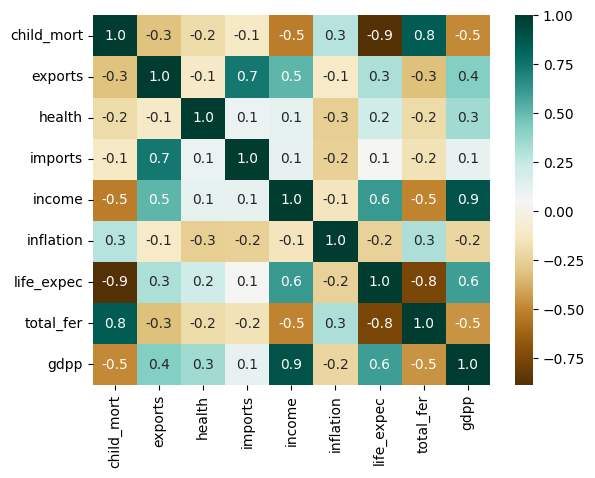

In [ ]:
# Create a correlation map of features to explore relationships
# between each of them.

sns.heatmap(country_df.corr(), annot=True, fmt='.1f', cmap='BrBG')

This **heatmap** shows some expected correlations, such as: 
* Child mortality & Life expectancy
* Income & Life expectancy
* Income & GDPP
* Exports & GDPP
* Imports & Exports

There is also a strong correlation between *total_fer* (i.e. the number of children born to each woman with the current age-fertility rates) and child mortality. A high child mortality is accompanied by a greater number of births for these mothers, indicating the sad reality of needing to have more children, in the hope that some of them reach adulthood.

Next, we will plot the independant features against *Child mortality*, and then against *GDPP*.

**Child mortality**

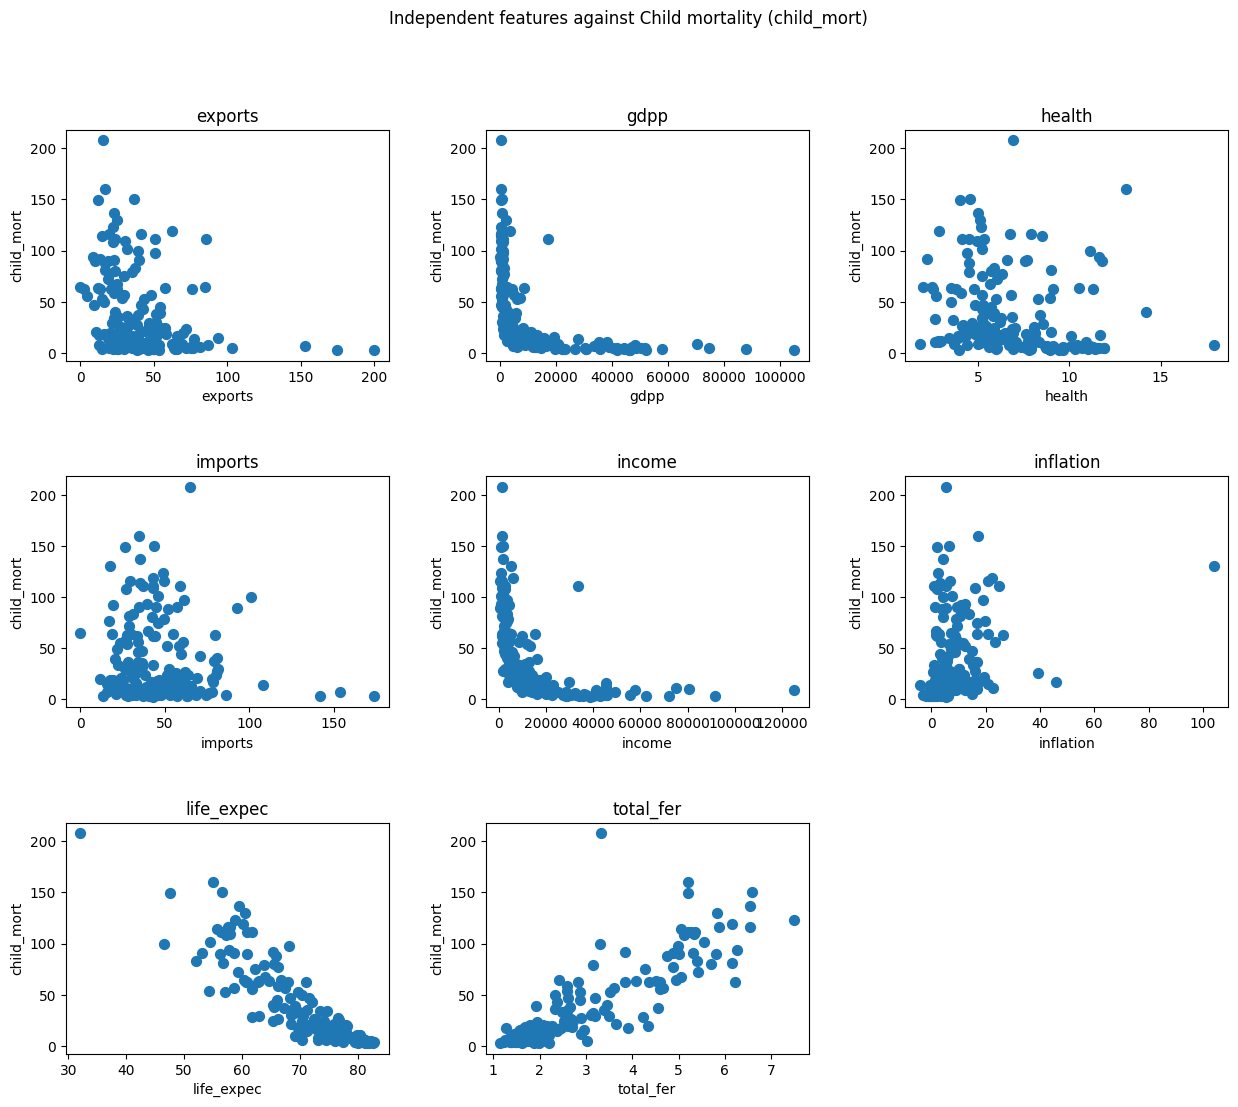

In [ ]:
# Explore the continuous independent features against "child_mort"
# using scatter plots.

# Create function to generate the scatter plots
def scatter_plots(x, y):
    plt.scatter(x, y, s=50)
    plt.suptitle('Independent features against Child mortality (child_mort)')
    plt.title(x.name)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

# Plot independant features against "child_mort"
plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5) 

# Exclude "child_mort" from the combinations
features_plot = country_df.columns.difference(['child_mort'])

# Iterate features, and create scatter plots for each of them
for i, feat in enumerate(features_plot):
    plt.subplot(3, 3, i + 1)
    scatter_plots(country_df[feat], country_df['child_mort'])

plt.show()

The following plots look promising for separating into clusters: 
* GDPP vs Child mortality
* Income vs Child mortality  
  *These two plots have an extremely similar shape.*  

* Exportations vs Child mortality  
  *There is a visible pattern with this plot, and it could be an indicator of child labour.* 

The plot "Life expectation vs Child mortality" also shows a strong correlation, but it is probably not worth investigating as it is merely stating the obvious: high child mortality is correlated with low lifespan expectation. 

**GDPP**

We will now plot these independant features against *GDPP*.

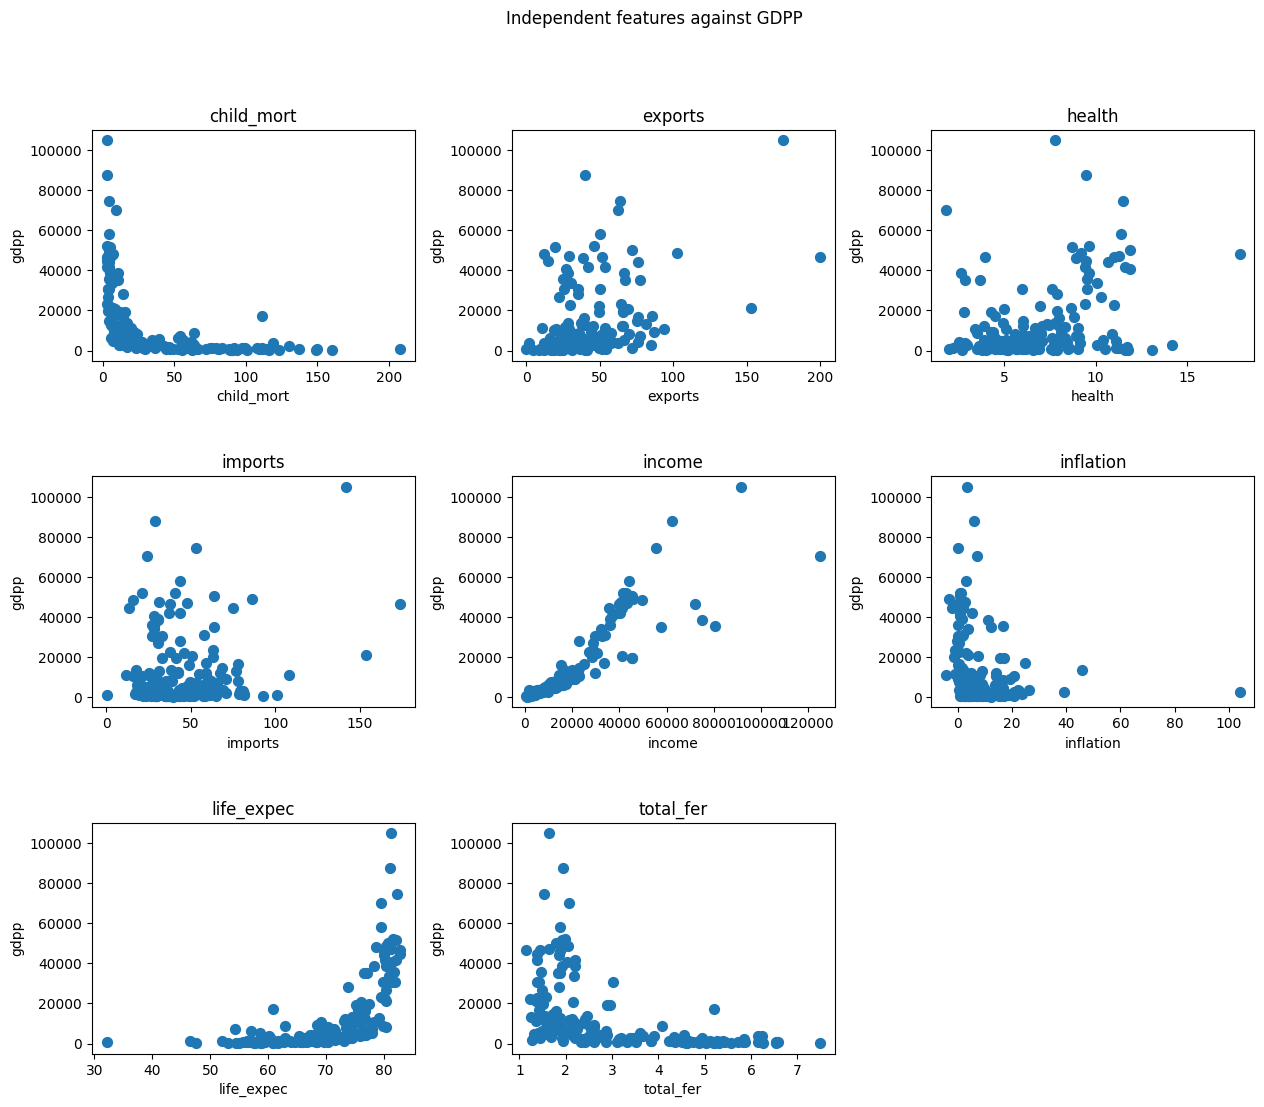

In [ ]:
# Explore the continuous independent features against "gdpp"using scatter plots.

# Create function to generate the scatter plots
def scatter_plots(x, y):
    plt.scatter(x, y, s=50)
    plt.suptitle('Independent features against GDPP')
    plt.title(x.name)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

# Plot independant features against "child_mort"
plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5) 

# Exclude "child_mort" from the combinations
features_plot = country_df.columns.difference(['gdpp'])

# Iterate features, and create scatter plots for each of them
for i, feat in enumerate(features_plot):
    plt.subplot(3, 3, i + 1)
    scatter_plots(country_df[feat], country_df['gdpp'])

plt.show()

The following plots looks promising for separating into clusters: 
* Child mortality vs GDPP  
  *This plot shows that high Child mortality is correlated with low GDPP*

* Life expectancy vs GDPP  
  *This plot has a similar shape, but mirrored, indicating a high Life expectancy with a high GDPP.*  

* Health vs GDPP
* Inflation vs GDPP

**Pairplot**

We will now create pairplots for all variables (as per instructions given for this task). 

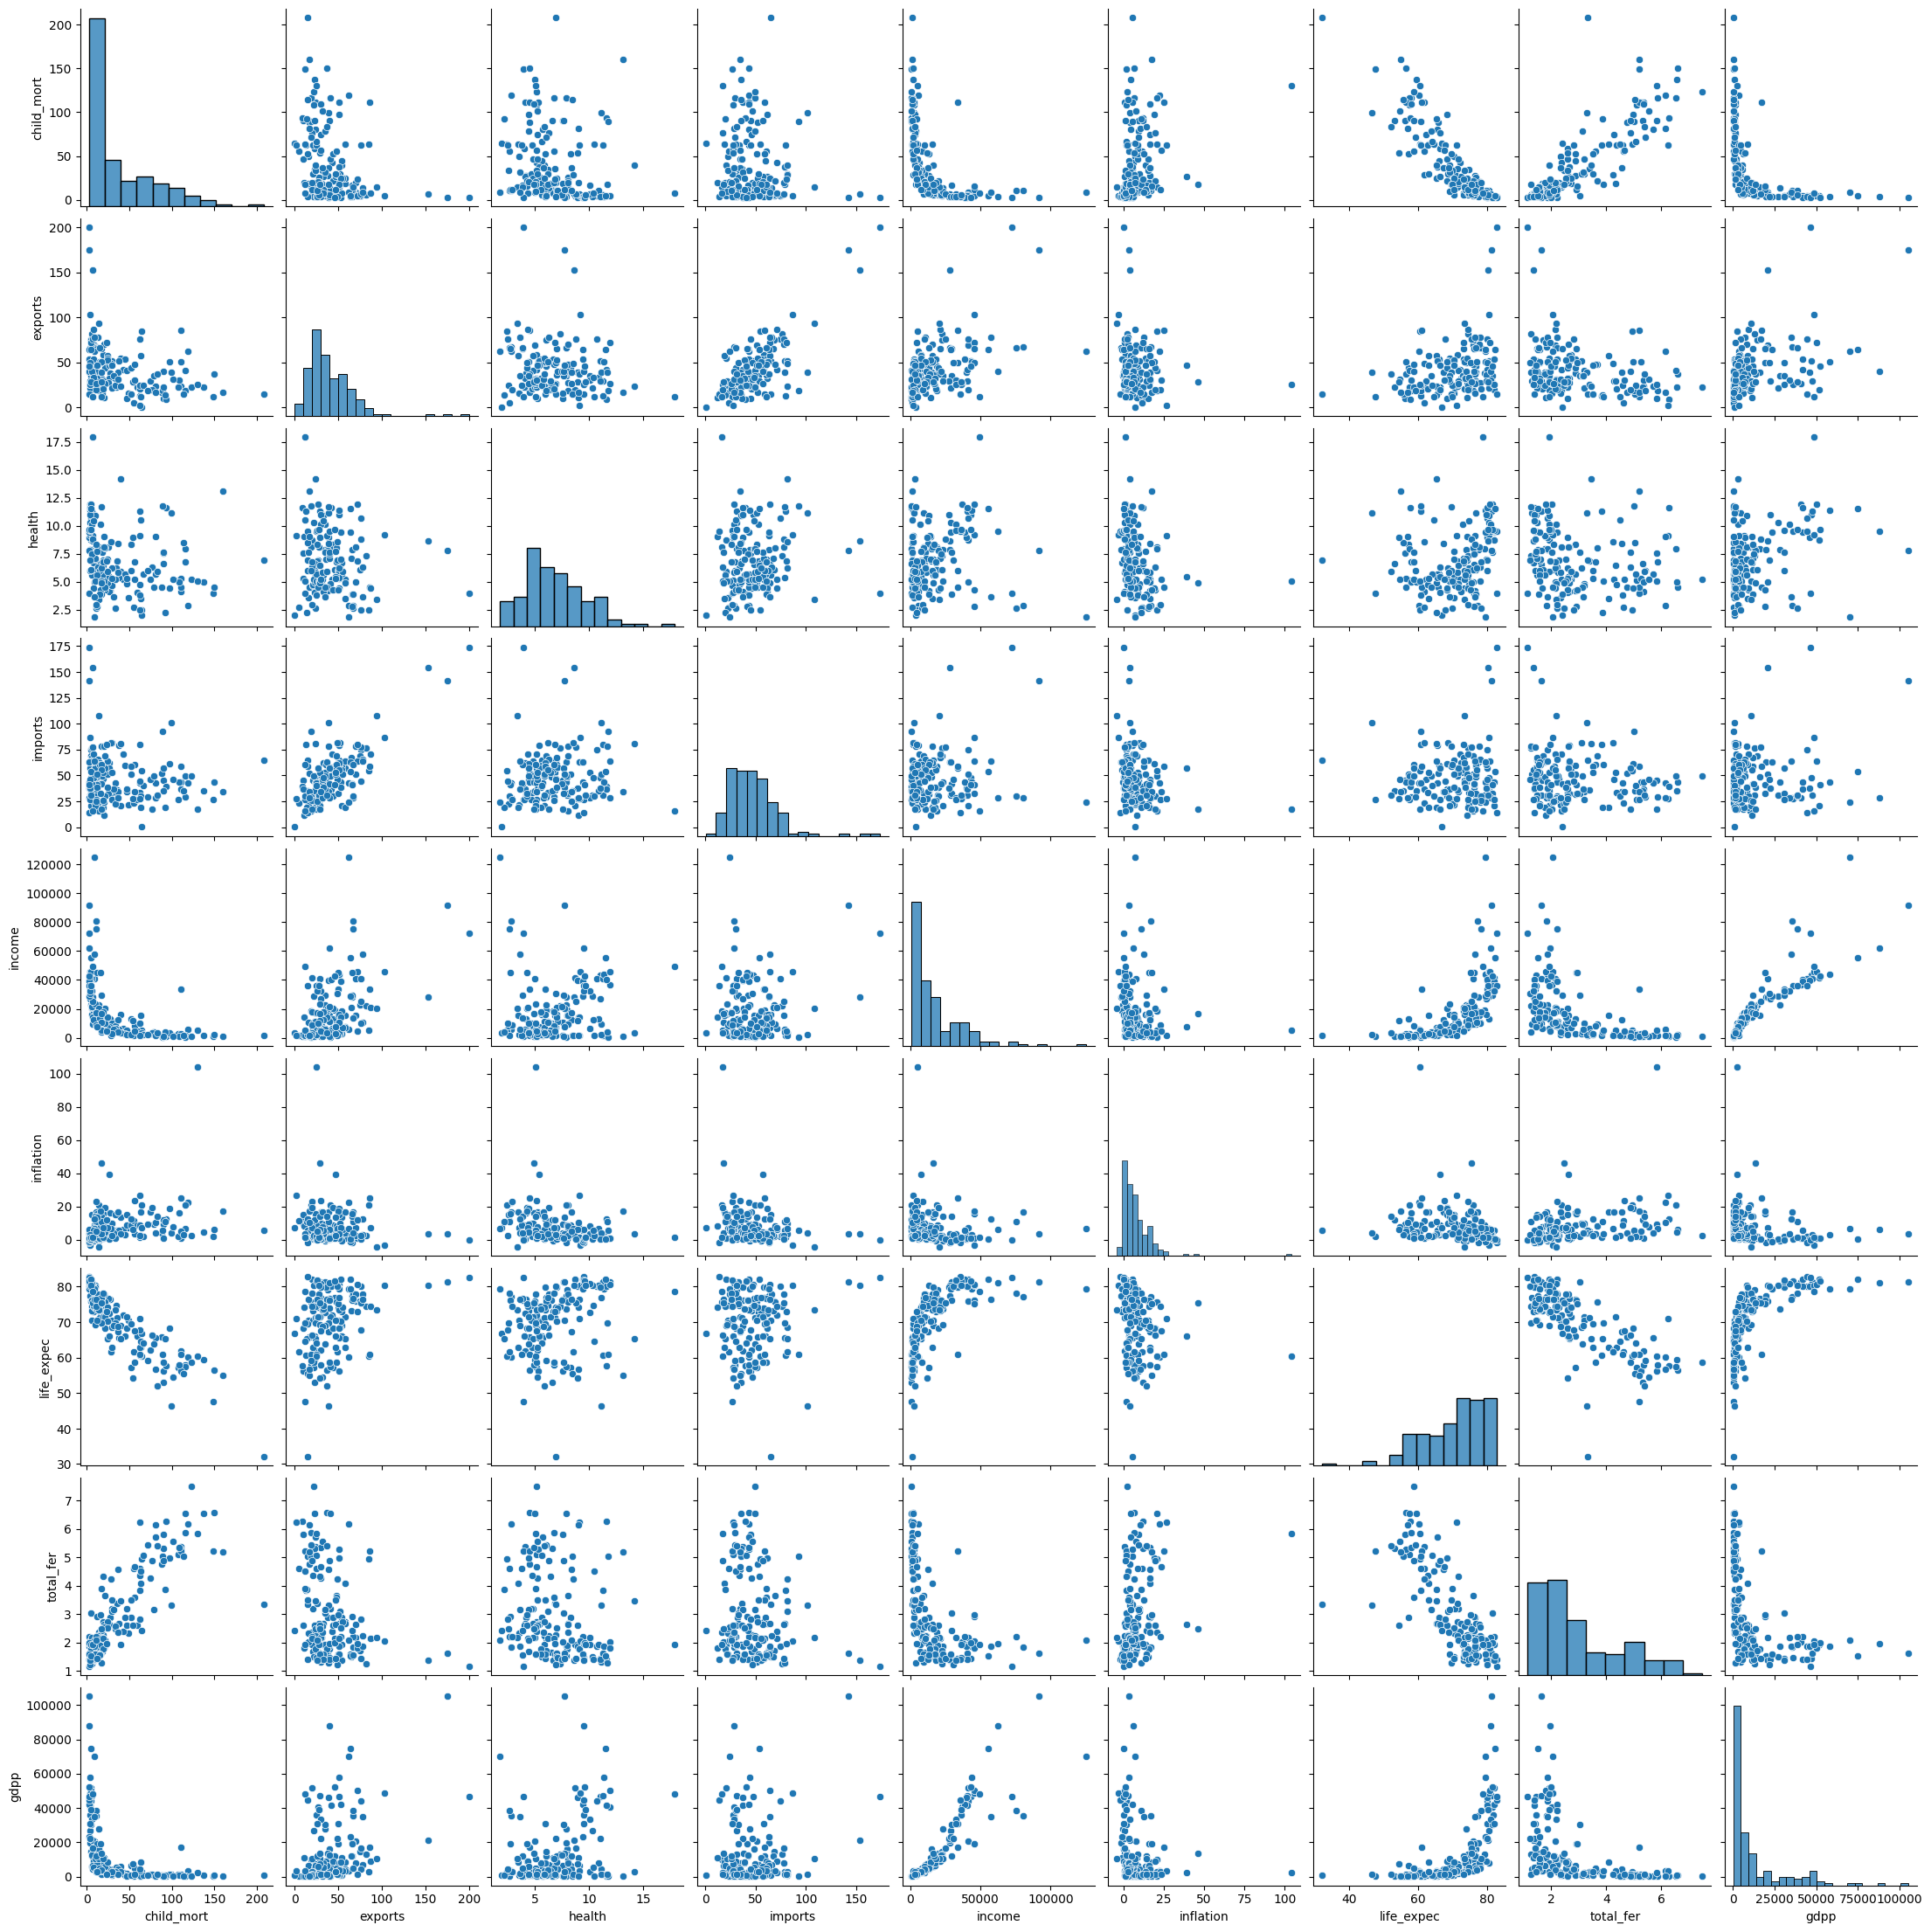

In [ ]:
# Create a pair plot
sns.pairplot(country_df)
plt.show()

## Scaling the Data 

Scaling will be performed using the *MinMaxScaler*.

In [ ]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(country_df)

## K-Means Clustering

### Selecting K

We will use the elbow and silhouette score method in order to find the optimal number of clusters.

**Elbow score method**

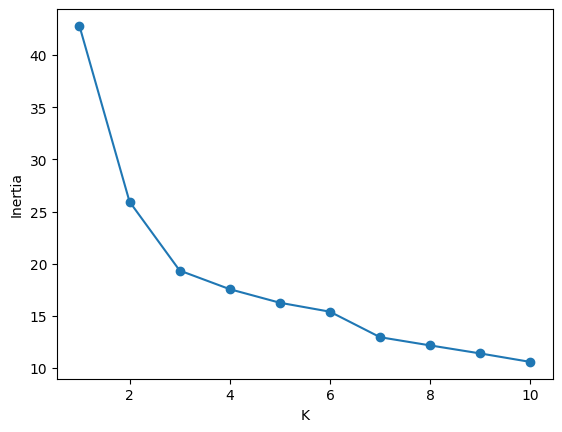

In [ ]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k, r):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled, 10, rseed)

Based on the elbow method, the elbow point is at 3 clusters.

We will now compute the silhouette score for clustering. 

**Silhouette score method**

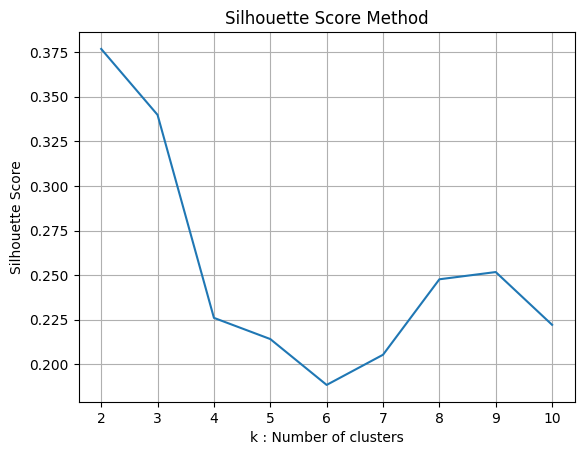

In [ ]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(visible=True)
plt.show()

Based on the silhouette method, the best score is K=2, followed closely by K=3, then we see a sharp drop of the score for K=4 and beyond.  
So, our best K value will be either 2 or 3. 

Based on both the elbow and silhouette method, **we will therefore choose a value of K=3** for the optimal number of clusters. 

In [ ]:
# Optimal value for K (optimal number of clusters)
k_optimal = 3

## Fitting a K-Means model with the selected K value

In this section, we fill fit the K-Means model with optimal K value = 3, and random state seed = 42 ("rseed" defined at the beginning of this notebook).

We will then count the number of records for each cluster, and check the model performance using the silhouette coefficient.

In [ ]:
# Fit the K-Means model with optimal K value "k_optimal"
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=rseed)
y_predict = kmeans.fit_predict(df_scaled)

In [ ]:
# Count the number of records in each cluster
unique, counts = np.unique(y_predict, return_counts=True)
clusters_count = dict(zip(unique, counts))

# Print results
print('Number of records for each cluster:')
for each in clusters_count:
    print(f'Cluster {unique[each]} => {counts[each]} records')

Number of records for each cluster:
Cluster 0 => 87 records
Cluster 1 => 35 records
Cluster 2 => 45 records


In [ ]:
# Check model performance with the silhouette coefficient

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(df_scaled, y_predict)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.33976487765323604


## Predictions

In [ ]:
# Add the predicted cluster label column to the original dataframe
country_df['cluster'] = pd.Series(y_predict, index=country_df.index)

## Visualisation of clusters

*Instructions: Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.*


### Label the groups of countries.

Before visualising the required plots (Child mortality vs GDPP, and Inflation vs GDPP), we need the tackle first the label names (clusters). 

With the elements provided in the dataset, we cannot classify them as "least developed, developing, and developed" because we would need more information to refine these criteria.  
(Information such as: access to driking water, sanitation and hygiene, levels of pollution, infrastructures, malnutrition, crime rates, etc.) 

We could classify the groups of countries from highest to lowest, but it may be too vague. 

Since we have access to the average income per capita in the dataset, we can use this information to classify our three clusters based on the income (Low, Medium, High). 

First, we need to see which label belongs to which cluster. To do so, we will compare the average and the median income for each cluster (group of countries).   

In [ ]:
# Calculate mean and median Income
income_mean = country_df.groupby(['cluster'])['income'].mean().astype(int)
income_median = country_df.groupby(['cluster'])['income'].median().astype(int)

# Display results 
print(f'Mean (average) income by {income_mean} \n')
print(f'Median income by {income_median} \n')

Mean (average) income by cluster
0    12644
1    45802
2     3555
Name: income, dtype: int32 

Median income by cluster
0    10500
1    40400
2     1850
Name: income, dtype: int32 



From these results, we can now classify our clusters as follows: 

* **0 = Medium income** (Average 12,644; Median 12,500)
* **1 = High income** (Average 45,800; Median 40,400)
* **2 = Low income** (Average 3,555; Median 1,850)

Earlier on, we also calculated the number of countries in each cluster. Let's now apply this information to the groups of countries (clusters).  
* 45 countries on a low income (low to low-middle)
* 87 countries on a medium income
* 35 countries on a high income (high-middle to high)

We will now configure a function displaying the handles/labels in the correct order for the plots' legend.

In [ ]:
# Function reordering the labels (clusters) for the plots' legend
def label_names(handles, labels):
    # Renaming the labels: 0 = Medium; 1 = High; 2 = Low
    labels[:] = ['Medium', 'High', 'Low']

    # Reordering the labels for display
    new_order = [2, 0, 1]

    plt.legend([handles[i] for i in new_order], [labels[i] for i in new_order], 
               title='Income')

We can now generate the plots with the correct legend.

**Child mortality vs GDPP**

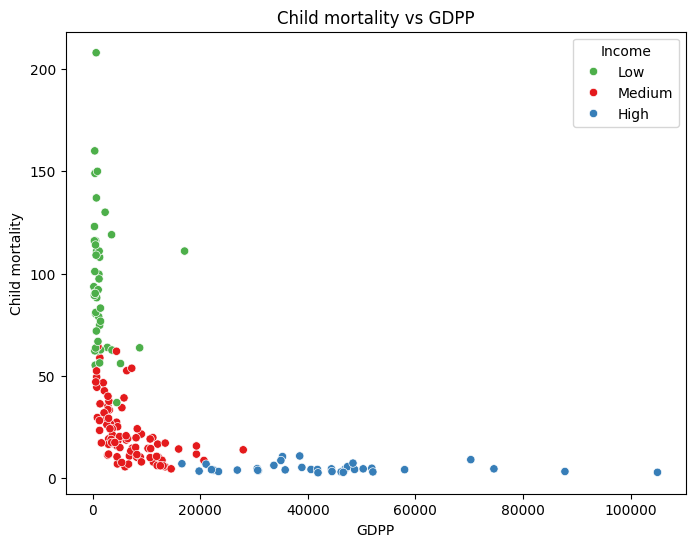

In [ ]:
# Visualisation of clusters: child mortality vs gdpp
plt.figure(figsize=(8, 6))
sns.scatterplot(x='gdpp', y='child_mort', hue=y_predict, palette='Set1', 
                data=country_df)
plt.title('Child mortality vs GDPP')
plt.xlabel('GDPP')
plt.ylabel('Child mortality')

handles, labels = plt.gca().get_legend_handles_labels()
label_names(handles, labels)

plt.show()

This plot shows a strong correlation between Child mortality and GDPP. The higher the GDPP, the less Child mortality per country. As we have already seen, the same trends apply to Income levels. 

We also see that most countries on a low income are concentrated in a small GDPP range (less than £10k), and experience the highest levels of Child mortality. 

Countries on a medium income are more disparate, although still concentrated in a small GDPP range (less than £20k). However, some of them experience the same low level of Child mortality as countries on a high income, whilst others suffer a much higher Child mortality. It could be due to access (or lack of access) to healthcare, sanitation, drinking water, etc.

Most countries on a high income are spread on a broader GDPP range (£20k to £55k), with only four countries over £60k. All these countries experience a low Child mortality.

**Inflation vs GDPP**

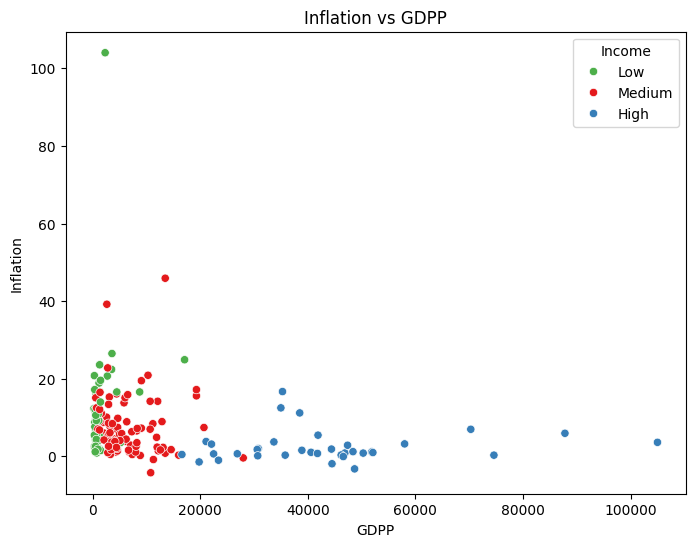

In [ ]:
# Visualisation of clusters: inflation vs gdpp
plt.figure(figsize=(8, 6))
sns.scatterplot(x='gdpp', y='inflation', 
                data=country_df, hue=y_predict, palette='Set1')
plt.title('Inflation vs GDPP')
plt.xlabel('GDPP')
plt.ylabel('Inflation')

handles, labels = plt.gca().get_legend_handles_labels()
label_names(handles, labels)

plt.show()

This plot shows that countries with a low GDPP (GDP per capita) are more prone to experience higher inflation rates, but GDPP appears to be only one factor among many others, not the main factor explaining inflation rated. We see for example that a significant number of high income countries (around the £40k-mark) experience a similar level of inflation as countries with low and medium income levels.  

The higher inflation rates (including outliers) can often be explained by factors such as wars, civil wars, political turmoil, global oil markets, etc.

A quick look at the 20 countries with the highest inflation rates (see below) corroborates this observation.  
For example:
* Political turmoil (Venezuela, Argentina…)
* Global oil markets (Timor-Leste, Saudia Arabia, Brunei…)
* Civil wars (Sudan, Nigeria, Yemen…)

In [ ]:
country.sort_values(by=['inflation'], ascending=False).head(20)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.9,75.4,2.47,13500
103,Mongolia,26.1,46.7,5.44,56.7,7710,39.2,66.2,2.64,2650
149,Timor-Leste,62.6,2.2,9.12,27.8,1850,26.5,71.1,6.23,3600
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.9,60.9,5.21,17100
165,Yemen,56.3,30.0,5.18,34.4,4480,23.6,67.5,4.67,1310
140,Sri Lanka,11.2,19.6,2.94,26.8,8560,22.8,74.4,2.20,2810
3,Angola,119.0,62.3,2.85,42.9,5900,22.4,60.1,6.16,3530
5,Argentina,14.5,18.9,8.10,16.0,18700,20.9,75.8,2.37,10300
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.8,57.5,6.54,334


## Conclusion

As shown on the pairplot below, our model (dividing the countries into three groups, which we have roughly classified as low, medium, and high income) allows us to visualise strong socio-economic trends when the features are plotted against factors on a personal/individual level, such as child mortality, life expectancy, number of children per mother, individual income, and GDPP.

Health is a good example of that. It is strongly correlated with death data (life expectancy and child mortality), as well as personal wealth (income or GDPP), but does not show much valuable trends when analysing economic factors at the national level, such as imports, exports or inflation rates.

Economic-oriented data at the national level (e.g. imports, exports, or inflation rates) also display some interesting trends, but  need to be refined with additional factors in order to become significative.

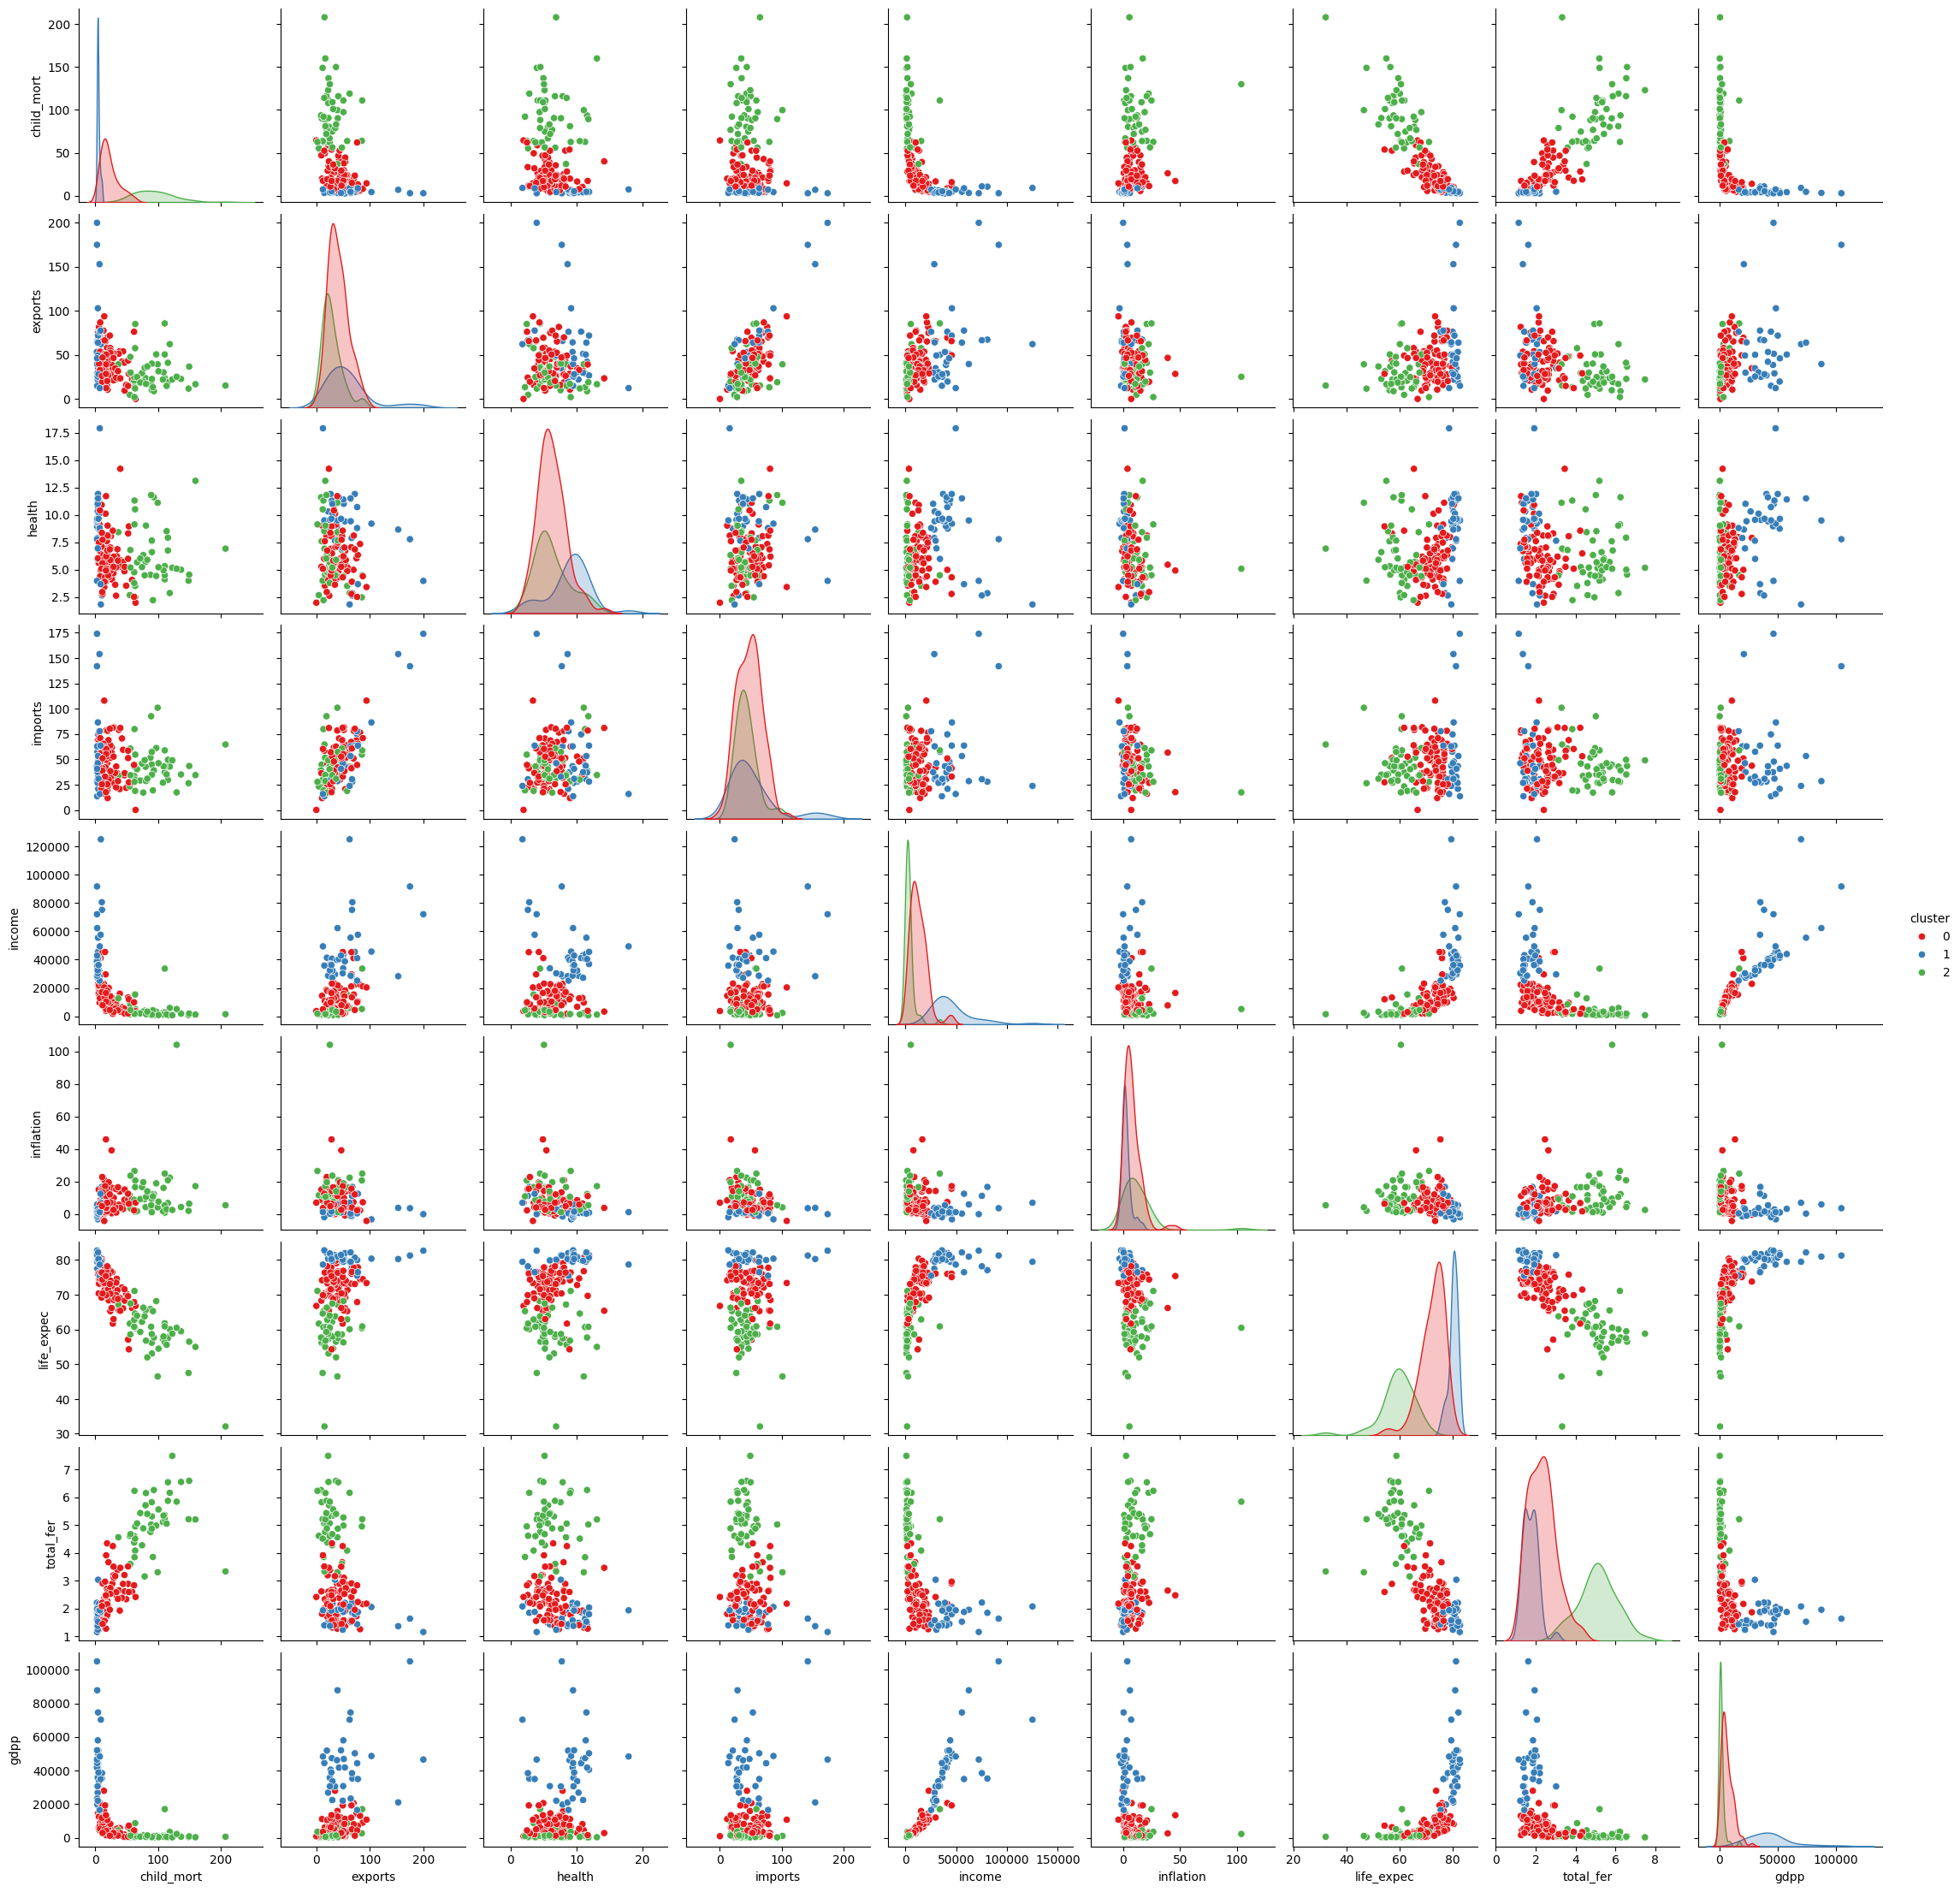

In [ ]:
sns.pairplot(country_df, hue='cluster', palette='Set1')
plt.show()